# Project : Analysing Trump's Tweets.

* Date   : 2020-03-23
* Tweets : 46,760

Source of the tweets : http://www.trumptwitterarchive.com/archive.


# Hypotheses to check for:

- Is there a relationship between engagement and source type?
- Does tweet's sentiment changes during time?
- Is there a relationship between Retweet count/ Favorite count and time created? what kind?
- Is there a relationship between word choice and engagement? what kind?
- Does word choice changes over time? How? what is the impact on engagement?
- Does number of tweets sent per day impact engagement?
- Is Trump systematically uses specific words to get more engagements?

# Goal:

* Predict whether tweet was sent prior to presidency or as the president

* Predict whether tweet has positive sentiment or not

# Limitations:

-- Daily tweet engagements can be impacted by external factors such as natural disasters, political reasons etc.

-- Sentiments can be adjusted better for more accuracy.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

from datetime import date

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import nltk 

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix

from sklearn import metrics

import demoji

from sklearn.linear_model import LogisticRegression , LinearRegression


%matplotlib inline
plt.style.use('seaborn')

#  Initial Stats

In [2]:
path = './trump_tweet.json'
data = pd.read_json(path,convert_dates=True)
# data

In [3]:
df = data.copy()

In [4]:
print(f'Rows: {df.shape[0]}\nColumns:{df.shape[1]}\nColumn Names :{df.columns.values}')

Rows: 46760
Columns:7
Column Names :['source' 'text' 'created_at' 'retweet_count' 'favorite_count'
 'is_retweet' 'id_str']


In [5]:
df.describe()

,retweet_count,favorite_count,is_retweet,id_str
count,46760.000000,46760.000000,46702.000000,4.676000e+04
mean,7139.992002,23275.166339,0.070853,6.948758e+17
std,11472.783368,44521.069557,0.256583,3.387586e+17
min,0.000000,0.000000,0.000000,1.698309e+09
25%,30.000000,16.000000,0.000000,3.916754e+17
50%,822.000000,119.000000,0.000000,6.295806e+17
75%,12011.500000,29571.500000,0.000000,1.038787e+18
max,369530.000000,879647.000000,1.000000,1.241897e+18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46760 entries, 0 to 46759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   source          46760 non-null  object             
 1   text            46760 non-null  object             
 2   created_at      46760 non-null  datetime64[ns, UTC]
 3   retweet_count   46760 non-null  int64              
 4   favorite_count  46760 non-null  int64              
 5   is_retweet      46702 non-null  float64            
 6   id_str          46760 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 2.5+ MB


In [7]:
df.isnull().sum()

source             0
text               0
created_at         0
retweet_count      0
favorite_count     0
is_retweet        58
id_str             0
dtype: int64

# Cleanining & Transforming 

In [8]:
#drop Unnecessary columns
df = df.drop(columns='id_str',index=1)

In [9]:
# some of the values in is_retweet are null which will be replaced by 0
df['is_retweet'].fillna(value=0,inplace=True)
df.isnull().sum()

source            0
text              0
created_at        0
retweet_count     0
favorite_count    0
is_retweet        0
dtype: int64

In [10]:
# extract year , month , day , and hour and add them as new features to df
# Change index to created_at

df['year_created']=df.created_at.dt.year
df['date_created']=df.created_at.dt.date
df['hour_created']=df.created_at.dt.hour
df['weekday_created']=df.created_at.dt.weekday
df = df.set_index('created_at').sort_values('created_at')


# No need to use tweets with is_retweet = 1 
* removing them should not impact the overall result since the number of sample for is_retweet = 1 is low and the goal is to analyze tweets only.

In [11]:
df.groupby('is_retweet').count()

,source,text,retweet_count,favorite_count,year_created,date_created,hour_created,weekday_created
is_retweet,,,,,,,,
0.0,43450,43450,43450,43450,43450,43450,43450,43450
1.0,3309,3309,3309,3309,3309,3309,3309,3309


In [12]:
df = df[df.is_retweet == 0]
df.groupby('is_retweet').count()

,source,text,retweet_count,favorite_count,year_created,date_created,hour_created,weekday_created
is_retweet,,,,,,,,
0.0,43450,43450,43450,43450,43450,43450,43450,43450


In [13]:
# no need to keep its feature column anymore
df = df.drop(columns='is_retweet',axis=1)

In [14]:
# df.head()

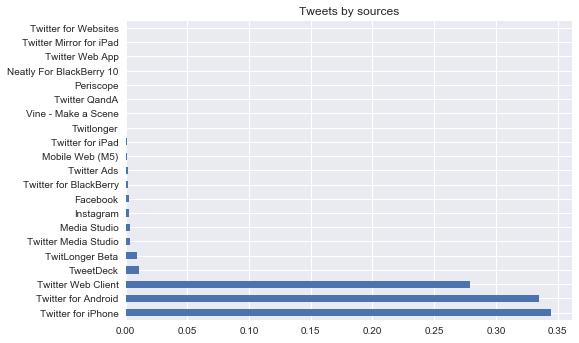

In [15]:
# Checking sources 21
df.source.value_counts(normalize=True).plot(kind='barh').set_title('Tweets by sources');

## Drop sources that have less than 1000 tweets


In [16]:
df = df.groupby('source').filter(lambda x: len(x) > 1000)

In [17]:
df.source.unique()

array(['Twitter Web Client', 'Twitter for iPhone', 'Twitter for Android'],
      dtype=object)

In [18]:
# 3 main sources are 
#     1-  'Twitter Web Client'   => 'web'
#     2-  'Twitter for iPhone'   => 'iPhone'
#     3-  'Twitter for Android'  => 'Android'

df.source = df.source.map({'Twitter Web Client':'Web','Twitter for iPhone':'iPhone' , 'Twitter for Android':'Android'})
df.source.unique()

array(['Web', 'iPhone', 'Android'], dtype=object)

In [19]:
df.source.value_counts().sort_values().index

Index(['Web', 'Android', 'iPhone'], dtype='object')

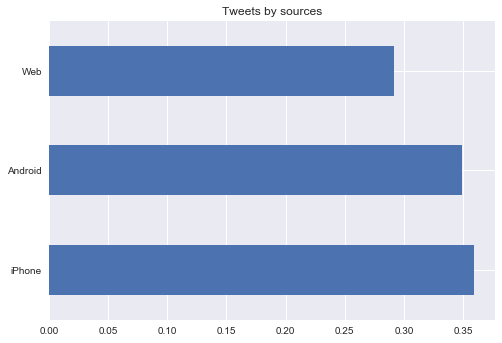

In [20]:
df.source.value_counts(normalize=True).plot(kind='barh').set_title('Tweets by sources');

# Plotting Tweets per sources with 1000+ tweets

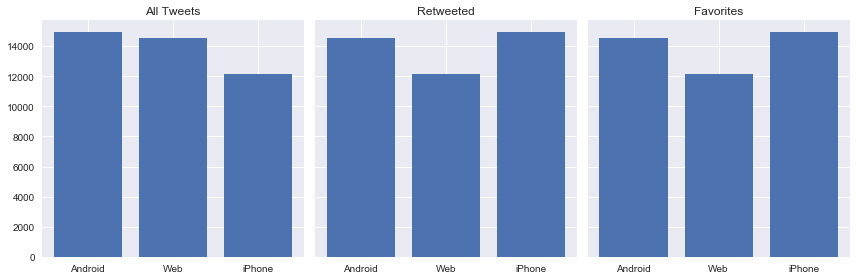

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True,sharey=True)
axs[0].bar(df.source.value_counts().index,df.source.value_counts())
axs[0].set_title('All Tweets')
axs[1].bar(df.groupby(by='source').retweet_count.count().index,df.groupby(by='source').retweet_count.count())
axs[1].set_title('Retweeted')
axs[2].bar(df.groupby(by='source').favorite_count.count().index,df.groupby(by='source').favorite_count.count())
axs[2].set_title('Favorites')

fig.tight_layout()
plt.show();

# Drop years that have less than 1000 tweets


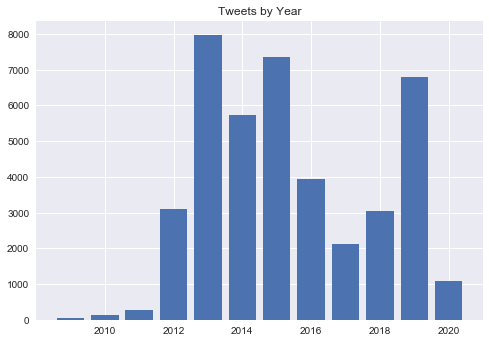

In [22]:
plt.bar(df.groupby(by='year_created').text.count().index,df.groupby(by='year_created').text.count());
plt.title('Tweets by Year');

# plot years that have more than 1000 tweets
* Drop 2020 since it's not a full year and number of tweets are not enough yet

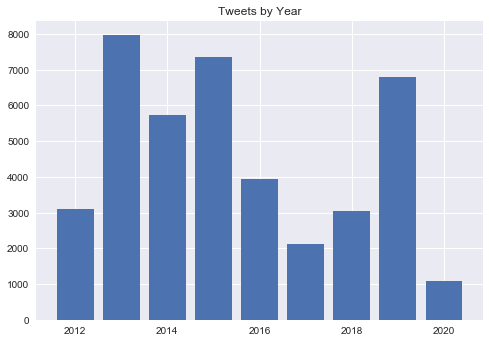

In [23]:
df = df[df.year_created >= 2012]
plt.bar(df.groupby(by='year_created').text.count().index,df.groupby(by='year_created').text.count());
plt.title('Tweets by Year');

# Using Tweet's Year as category
            
   * Create a feature column called is_president using year of the tweet
    
    a) is_president = true    2016 - 2020
    
    b) is_president = false   2012 - 2016
    


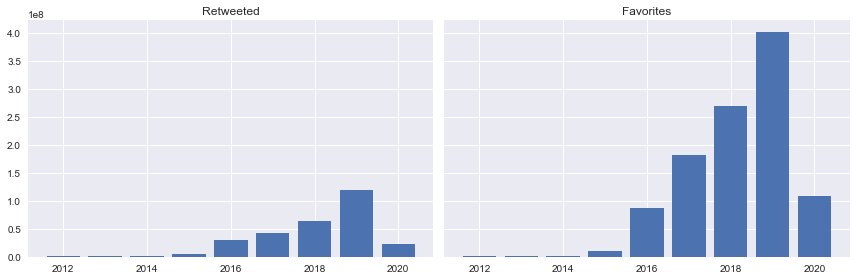

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True,sharey=True)

axs[0].bar(df.groupby(by='year_created').retweet_count.sum().index,df.groupby(by='year_created').retweet_count.sum())
axs[0].set_title('Retweeted')
axs[1].bar(df.groupby(by='year_created').favorite_count.sum().index,df.groupby(by='year_created').favorite_count.sum())
axs[1].set_title('Favorites')

fig.tight_layout()
plt.show()

 There is a vivid difference in engagements before and after presidency


In [25]:
df['is_president']= np.where(df.year_created<2016 , 0 , 1)


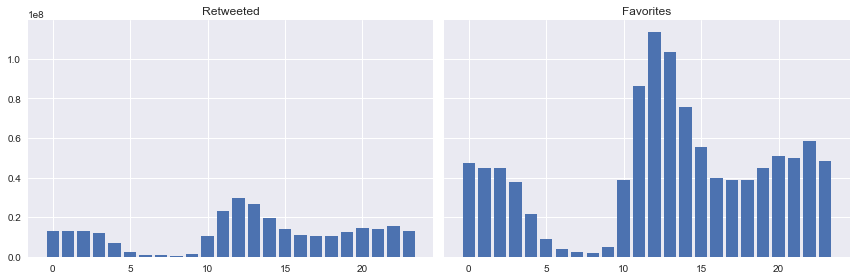

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True,sharey=True)

axs[0].bar(df.groupby(by='hour_created').retweet_count.sum().index,df.groupby(by='hour_created').retweet_count.sum())
axs[0].set_title('Retweeted')
axs[1].bar(df.groupby(by='hour_created').favorite_count.sum().index,df.groupby(by='hour_created').favorite_count.sum())
axs[1].set_title('Favorites')

fig.tight_layout()
plt.show()

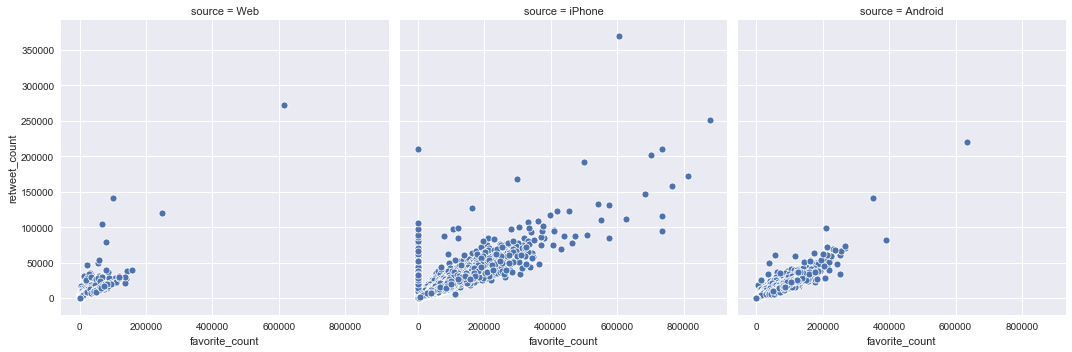

In [27]:
sns.relplot(x="favorite_count", y="retweet_count", data=df,col='source');

In [28]:
df.favorite_count.describe()
# std       44871.881011   =>  very high

count     41171.000000
mean      25766.816303
std       46287.416608
min           0.000000
25%          26.000000
50%         258.000000
75%       42778.500000
max      879647.000000
Name: favorite_count, dtype: float64

In [29]:
df.retweet_count.describe()

count     41171.000000
mean       7011.189769
std       11507.926672
min           0.000000
25%          25.000000
50%         621.000000
75%       12190.500000
max      369530.000000
Name: retweet_count, dtype: float64

# Multicollinearity Check

    * If two columns are highly correlated , drop one.

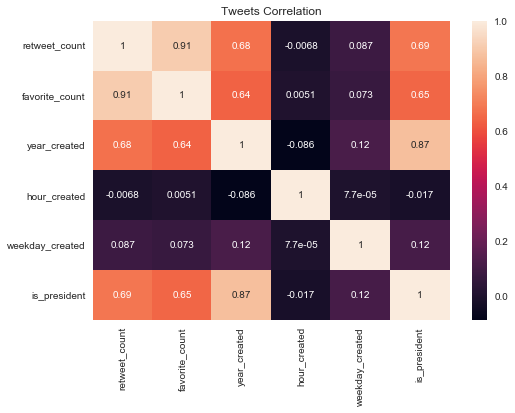

In [30]:
tweets = df.copy()
sns.heatmap( tweets.corr(),annot=True).set_title('Tweets Correlation');

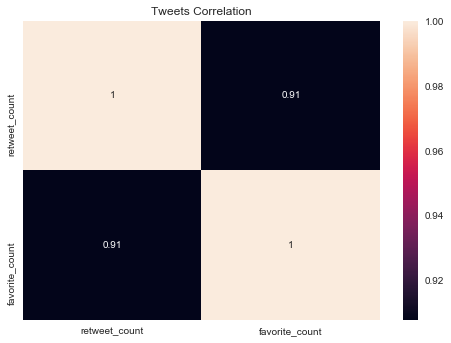

In [31]:
sns.heatmap( tweets[['retweet_count','favorite_count']].corr(),annot=True).set_title('Tweets Correlation');

 Retweet_count and favorite_count are highly correlated, to avoid Multicollinearity we will  drop favorite_count.

In [32]:
tweets.drop(columns='favorite_count',axis=1,inplace=True)

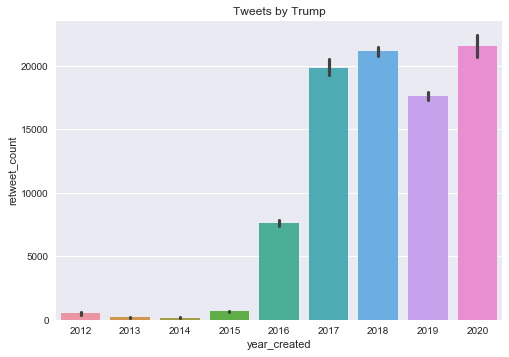

In [33]:
sns.barplot(x='year_created',y='retweet_count', data=tweets[['year_created','retweet_count']]).set_title('Tweets by Trump');

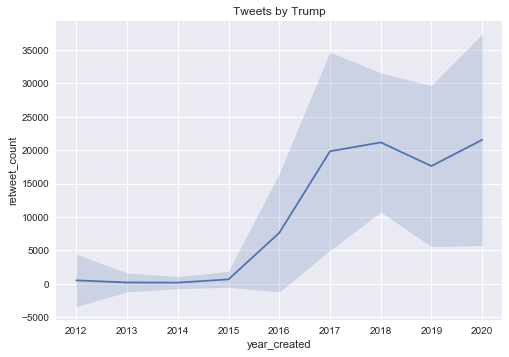

In [34]:
sns.lineplot(x="year_created", y="retweet_count", data=tweets,ci='sd').set_title('Tweets by Trump');

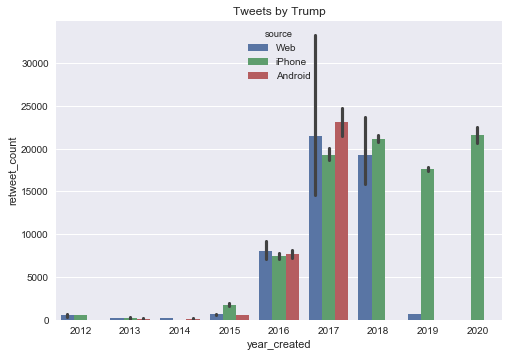

In [35]:
sns.barplot(x='year_created',y='retweet_count',hue='source', data=tweets[['year_created','retweet_count','source']]).set_title('Tweets by Trump');

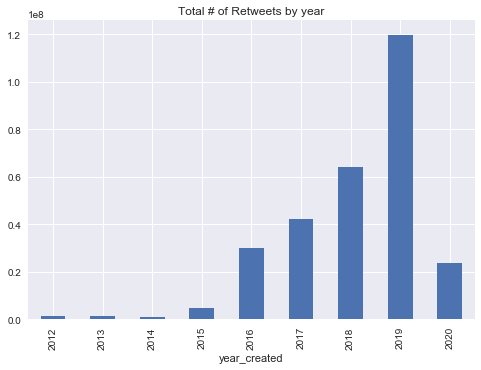

In [36]:
tweets.groupby('year_created').retweet_count.sum().plot.bar().set_title('Total # of Retweets by year');

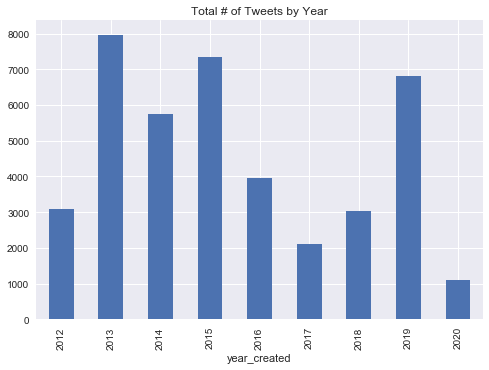

In [37]:
tweets.groupby('year_created').text.count().plot.bar().set_title('Total # of Tweets by Year');

# Checking for Trends and Seasonality in tweets

In [38]:
daily_tweets = tweets.groupby('date_created').retweet_count.sum()
daily_tweets[:]

date_created
2012-01-03       908
2012-01-04      3164
2012-01-05       537
2012-01-06      1192
2012-01-09       771
               ...  
2020-03-19    169491
2020-03-20     77815
2020-03-21    210098
2020-03-22    218675
2020-03-23      7777
Name: retweet_count, Length: 2847, dtype: int64

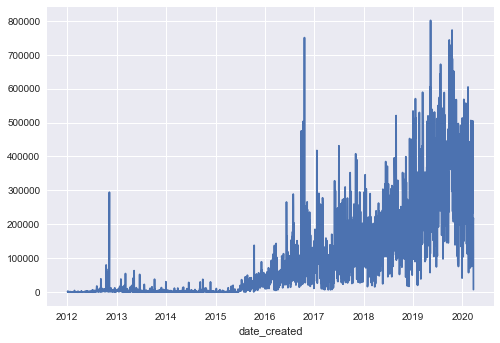

In [39]:
decomposition = seasonal_decompose(daily_tweets[:], period=1)  
fig = plt.figure();
fig = decomposition.trend.plot();
# fig.set_size_inches(20, 10);
decomposition

# by hour

In [40]:
hourly_tweets = tweets.groupby('hour_created').retweet_count.sum()
# hourly_tweets[:]

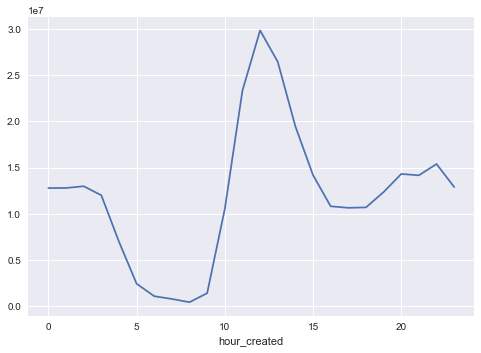

In [41]:
decomposition = seasonal_decompose(hourly_tweets[:], period=1)  
fig = plt.figure()  
fig = decomposition.trend.plot();


# Using Tweet's Sentiment in Our Analysis
            
   * Create a feature column called is_positive using sentiment score (1 most positive , -1 most negative)
    
    a) is_positive = true sentiment score   (0 , 1) 
    
    b) is_positive = false sentiment score  (-1 , 0)


In [42]:
tweets['sentiment'] = tweets.text.apply(lambda tweet:TextBlob(tweet).sentiment.polarity)

In [43]:
tweets['is_positive'] = tweets.sentiment.apply(lambda x: 1 if x >0 else 0)

In [44]:
tweets.groupby('is_positive').text.describe()

,count,unique,top,freq
is_positive,,,,
0,18326,18200,PRESIDENTIAL HARASSMENT!,10
1,22845,22709,MAKE AMERICA GREAT AGAIN!,33


In [45]:
tweets.groupby(['is_president','is_positive']).text.describe()

count unique  \
is_president is_positive                 
0            0            10297  10243   
             1            13864  13816   
1            0             8029   7959   
             1             8981   8894   

                                                                        top  \
is_president is_positive                                                      
0            0            For all of those who have been asking about on...   
             1            Vision remains vision until you focus, do the ...   
1            0                                     PRESIDENTIAL HARASSMENT!   
             1                                    MAKE AMERICA GREAT AGAIN!   

                         freq  
is_president is_positive       
0            0              5  
             1              3  
1            0             10  
             1             31

In [46]:
tweets.groupby(['is_president','is_positive']).retweet_count.describe()

count          mean           std  min     25%  \
is_president is_positive                                                     
0            0            10297.0    414.828785   2308.866465  0.0    15.0   
             1            13864.0    319.557487   1254.307084  0.0    10.0   
1            0             8029.0  16522.170631  13558.652936  0.0  7850.0   
             1             8981.0  16401.219129  12090.433709  0.0  8769.0   

                              50%      75%       max  
is_president is_positive                              
0            0               55.0    339.0  141644.0  
             1               29.0    248.0   50145.0  
1            0            14243.0  22045.0  369530.0  
             1            15024.0  21436.0  220796.0

In [47]:
daily_positive_tweets = tweets.groupby('date_created').is_positive.sum()

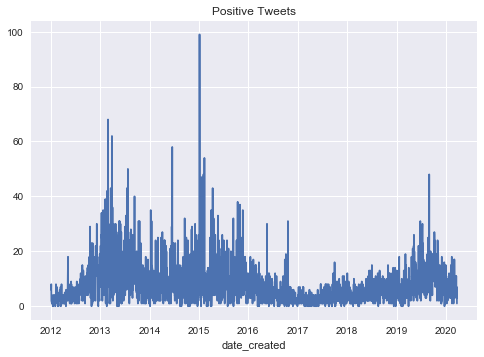

In [48]:
decomposition = seasonal_decompose(daily_positive_tweets[:], period=1)  
fig = plt.figure()  
fig = decomposition.trend.plot().set_title('Positive Tweets');


# Hypothesis 1:
## (Using Natural Language Processing)
    * Using tweet content we should be able to predict whether or not a given tweet is sent prior to presidency or as the president

 * Create an analyzer to clean tweets


In [49]:

def tweet_process(tweet):
    """
    1. Lower case tweets
    2. Remove urls|@|#
    3. use Stemming and Lemmetization
    4. Remove stop words
    5. Remove punctuations
    
    *** returns a List
    """
    tweet = tweet.lower() # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # remove URLs
    tweet = re.sub(r'@([^\s]+)', r'\1', tweet) # remove @ from usernames
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    tweet = emoji_pattern.sub(r'', tweet)
    
    
    
    emojis = demoji.findall(tweet) # find emoji to remove
    
    
    stop_words = set(stopwords.words('english') + list(punctuation))
    
    
    stemmer = SnowballStemmer('english', ignore_stopwords=True)
    tweet_words = TextBlob(tweet).words
    lemme_words = [word.lemmatize(pos='v') for word in tweet_words if word not in  stop_words ]
    
    list_of_words = [word for word in lemme_words ]

    return list_of_words


In [50]:
print(f'Original tweet:\n{tweets.text[0]}\n')
print(f"Processed tweet:\n{' '.join(tweet_process(tweets.text[0]))}")

Original tweet:
My @foxandfriends interview discussing the "Make America Great Again" Texas filing and the Iowa caucus http://t.co/HwnskYQT

Processed tweet:
foxandfriends interview discuss make america great texas file iowa caucus


## Using a pipeline to create our NLP model

    1. CountVectorizer to get count of each word
        a. ngram_range=(1, 4) to check word and phrases with up to 4 words
    2. TfidfTransformer to get Term Frequency Inverse Document Frequency of each word.
    3. MultinomialNB for classification



In [51]:
pipeline =Pipeline([
    ('bow', CountVectorizer(analyzer=tweet_process,ngram_range=(1, 4))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

## A - Predict whether Tweet is posted as president or prior to that.

In [52]:
TWEETS = tweets.text #feature matrix
label = tweets.is_president #target variable

# split data into train test splits

TWEETS_train, TWEETS_test, label_train, label_test = train_test_split(TWEETS, label)

pipeline.fit(TWEETS_train,label_train)
predictions = pipeline.predict(TWEETS_test)

In [53]:
null_accuracy = label_test.value_counts(normalize=True).max()
null_accuracy

0.5889439424851841

In [54]:
print('Prediction results: ');
null_accuracy = label_test.value_counts(normalize=True).max()
print(f'Null  Accuracy Score: {null_accuracy}')
model_accuracy = metrics.accuracy_score(label_test, predictions)
print(f'Model Accuracy Score: {model_accuracy}')
print('------------')
print(confusion_matrix(label_test,predictions))

print(classification_report(label_test,predictions))

Prediction results: 
Null  Accuracy Score: 0.5889439424851841
Model Accuracy Score: 0.8800155445448363
------------
[[5554  508]
 [ 727 3504]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6062
           1       0.87      0.83      0.85      4231

    accuracy                           0.88     10293
   macro avg       0.88      0.87      0.88     10293
weighted avg       0.88      0.88      0.88     10293



***** Our model can predict with 88% accuracy wether or not a tweet was posted as president or prior to that versus the null accuracy of 58%.

## B - Predict if tweet  has Positive sentiment or Negative

In [55]:
TWEETS = tweets.text
label = tweets.is_positive
TWEETS_train, TWEETS_test, label_train, label_test = train_test_split(TWEETS, label)
pipeline.fit(TWEETS_train,label_train)
predictions = pipeline.predict(TWEETS_test)

In [56]:
null_accuracy = label_test.value_counts(normalize=True).max()
null_accuracy

0.5594093072962207

In [57]:
null_accuracy = label_test.value_counts(normalize=True).max()
print(f'Null  Accuracy Score: {null_accuracy}')
model_accuracy = metrics.accuracy_score(label_test, predictions)
print(f'Model Accuracy Score: {model_accuracy}')
print('------------')
print(confusion_matrix(label_test,predictions))

print(classification_report(label_test,predictions))


Null  Accuracy Score: 0.5594093072962207
Model Accuracy Score: 0.7412804818808899
------------
[[2391 2144]
 [ 519 5239]]
              precision    recall  f1-score   support

           0       0.82      0.53      0.64      4535
           1       0.71      0.91      0.80      5758

    accuracy                           0.74     10293
   macro avg       0.77      0.72      0.72     10293
weighted avg       0.76      0.74      0.73     10293



* Our model can predict with 74% accuracy wether or not a tweet is positive or negative  versus the null accuracy of 55%.

# Hypothesis 2:
## (Using KMeans Clustering)
--Using Unsupervised Learning
- if we cluster tweets into two groups how accuratly can we predict if sent as president or prior

In [58]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist



In [59]:
tweet_stats = tweets.drop(columns=['text','source','date_created'], axis = 1)

In [60]:
tweet_stats

,retweet_count,year_created,hour_created,weekday_created,is_president,sentiment,is_positive
created_at,,,,,,,
2012-01-03 18:40:47+00:00,19,2012,18,1,0,0.800000,1
2012-01-03 19:15:22+00:00,24,2012,19,1,0,0.400000,1
2012-01-03 19:25:16+00:00,58,2012,19,1,0,0.078125,1
2012-01-03 19:32:41+00:00,142,2012,19,1,0,0.000000,0
2012-01-03 19:51:54+00:00,75,2012,19,1,0,-0.194444,0
...,...,...,...,...,...,...,...
2020-03-22 14:52:09+00:00,14893,2020,14,6,1,0.200000,1
2020-03-22 16:14:59+00:00,24304,2020,16,6,1,-0.108673,0
2020-03-22 17:32:30+00:00,26410,2020,17,6,1,-0.097222,0


### Finding best K using elbow method!

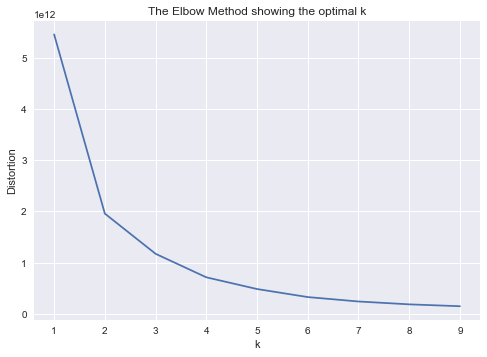

In [61]:
# We can make this a little easier by using the .interia() method available in KMeans

distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tweet_stats)
    distortions.append(kmeans.inertia_)


plt.plot(range(1, 10), distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [62]:
km=KMeans(n_clusters=2)
km.fit(tweet_stats)
km.labels_

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

## Cheking the clustering result against "is_president":
   - if we compare the clusering results against the manual labels we created to cluster tweets,
    we can see that our model classifed presidential tweets exaclty as we did manually and for 
    the tweets that were sent prior to presidency, our models match 78% of times.

In [63]:
print(confusion_matrix(tweets.is_president,km.labels_))
print('\n')
print(classification_report(tweets.is_president,km.labels_))

[[   35 24126]
 [10055  6955]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24161
           1       0.22      0.41      0.29     17010

    accuracy                           0.17     41171
   macro avg       0.11      0.21      0.15     41171
weighted avg       0.09      0.17      0.12     41171



## Cheking the clustering result against "is_positive":
-- it looks like that kmeans clustering results are less likely to be is_positive

In [64]:
print(confusion_matrix(tweets.is_positive,km.labels_))
print('\n')
print(classification_report(tweets.is_positive,km.labels_))

[[ 4595 13731]
 [ 5495 17350]]


              precision    recall  f1-score   support

           0       0.46      0.25      0.32     18326
           1       0.56      0.76      0.64     22845

    accuracy                           0.53     41171
   macro avg       0.51      0.51      0.48     41171
weighted avg       0.51      0.53      0.50     41171



In [68]:
from pandas.plotting import autocorrelation_plot


In [86]:
tweets.retweet_count.autocorr(lag=7)

0.6155060006207703

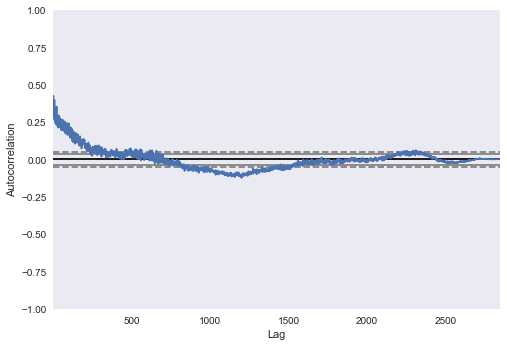

In [85]:
autocorrelation_plot(daily_positive_tweets)

In [70]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

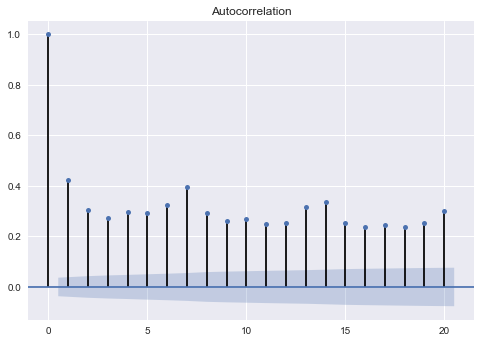

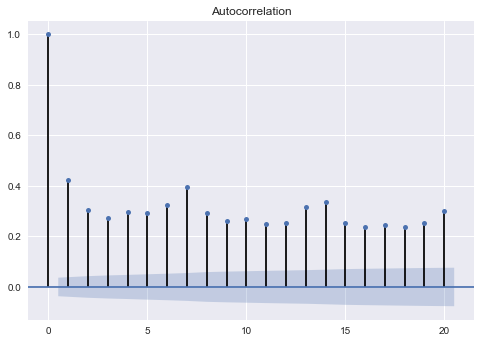

In [83]:
plot_acf(daily_positive_tweets,lags=20)

In [177]:
daily_df = tweets[['text']].resample('D').count().reset_index()
daily_df

,created_at,text
0,2012-01-03 00:00:00+00:00,10
1,2012-01-04 00:00:00+00:00,10
2,2012-01-05 00:00:00+00:00,5
3,2012-01-06 00:00:00+00:00,5
4,2012-01-07 00:00:00+00:00,0
...,...,...
2998,2020-03-19 00:00:00+00:00,6
2999,2020-03-20 00:00:00+00:00,4
3000,2020-03-21 00:00:00+00:00,8
3001,2020-03-22 00:00:00+00:00,13


In [178]:
line_coef = np.polyfit(daily_df.index,daily_df['text'],1)

In [179]:
polynomial_func = np.poly1d(line_coef)

In [180]:

pred = polynomial_func(daily_df.index)

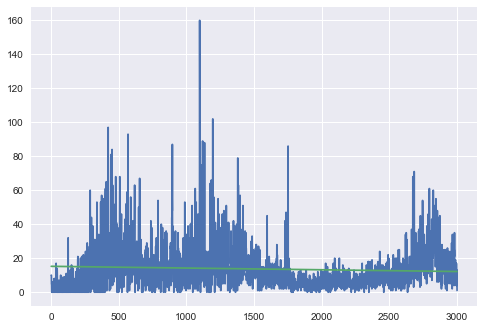

In [181]:
plt.plot(daily_df.index,daily_df.text)
plt.plot(daily_df.index,pred)

In [219]:
# daily_df

In [182]:
daily_df = tweets[['text']].resample('D').count()

diff = daily_df['text'].diff(periods=1)

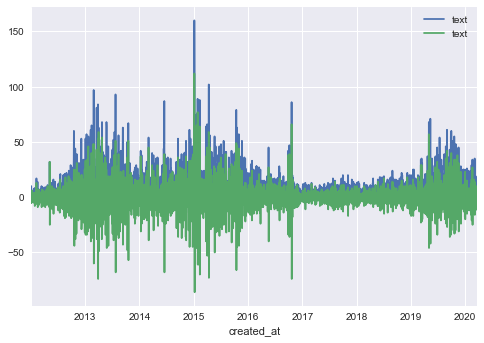

In [183]:
fig, ax = plt.subplots()
daily_df['text'].plot(legend = True)
diff.plot(legend=True)

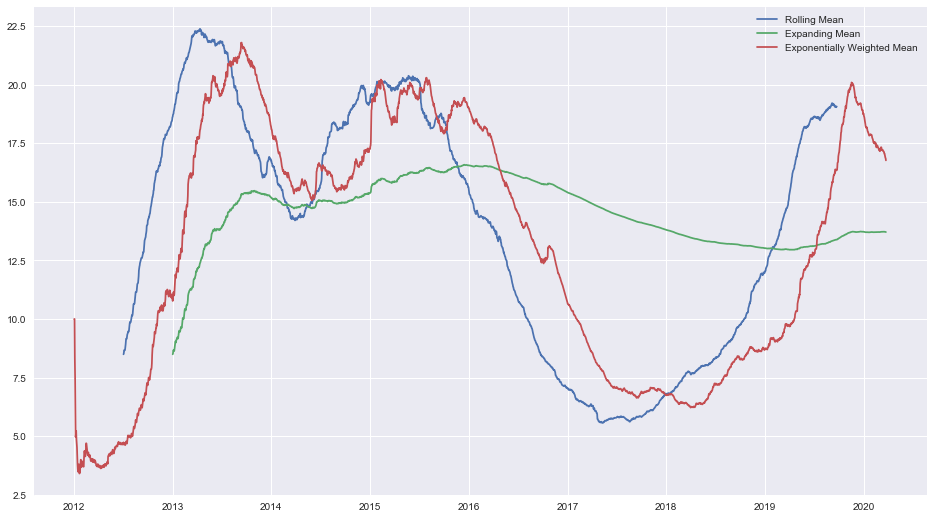

In [217]:

roll = daily_df.rolling(window=365,center=True).mean()
expand = daily_df.expanding(min_periods=365).mean()
expon = daily_df.ewm(span=365).mean()

plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
plt.plot(roll)
plt.plot(expand)
plt.plot(expon)

ax.legend(['Rolling Mean', "Expanding Mean",'Exponentially Weighted Mean']);
